<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2_Training%26Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's setup the workspace

## GitHub
Let's clone the GitHub repository containing the dataset, models, hyperparameters and utils file.

In [ ]:
!git clone https://github.com/DarioMameli/DL_Ass2
import sys
# Add the repository to the path
sys.path.insert(1, '/content/DL_Ass2/')

Cloning into 'DL_Ass2'...
remote: Enumerating objects: 1480, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1480 (delta 10), reused 29 (delta 10), pack-reused 1451
Receiving objects: 100% (1480/1480), 465.96 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (1454/1454), done.


## Pip Installs

In [ ]:
# Install the latest version of TensorFlow, which includes Keras (tf.keras)
#!pip install tensorflow --upgrade
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade
!pip install PrettyTable
!pip install saliency
!pip install lime
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=aa2aa07be1a1227962fc193d4e80b45dfd76b4e58bd8c6d078a738b1bf288dac
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.5 MB/s eta 0:00:00


## Packages

Let's import all the necessary functions and packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from keras import backend as backend
from keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
    UpSampling2D
)
from keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from dl_utils import plot_history
from dl_utils import load_or_build
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.applications as app
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
import gc
import json
from prettytable import PrettyTable
from keras import Model, ops

from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import minmax_scale
from lime import lime_image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
import warnings
warnings.filterwarnings('ignore')

## Global Variables

First of all we set the seed for reproducibility of the results, and the training flags.

**IMPORTANT**: these are the variables to set in order to control the execution of the code and activate more or less resource intensive operations, in the sense that you can decide to train the model(set True) or use the version that we have already trained and saved in github. Notice that in particular for the HEAVY_TRAINING flag, a crash of the system may occur if set to True for the high memory usage required. That is why all of the trained models are saved in the GitHub repository to abilitate the evaluation part without necessarily training first.
*   HEAVY_TRAINING
*   LIGHT_TRAINING
*   LIGHT_TRAINING_NOAUG



In [ ]:
SEED=33
HEAVY_TRAINING = False  # this is to activate the intensive process of training the 5 pretrained models with augmentation.
LIGHT_TRAINING = False  # this is to activate the less intensive process of training the tuned model WITH augmentation.
LIGHT_TRAINING_NOAUG = False # this is to activate the less intensive process of training the tuned model WITHOUT augmentation.

# Load data

Load the dataset

In [ ]:
# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/DL_Ass2/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        #file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

Preprocess the feature vectors:


*   Resize images to fit with the pretrained networks
*   **DO NOT** normalize data values as the pretrained networks expects input values in the range [0, 255]



In [ ]:
def resize_images(images, target_size):
  # Resizing all the images
  resized_images = []
  # Resize each image to the target size using LANCZOS resampling
  for img in images:
      resized_img = img.resize(target_size, Image.LANCZOS)
      resized_images.append(resized_img)
  # Convert the list of resized images to a NumPy array
  images_array = np.array([np.array(img) for img in resized_images])

  return images_array

In [ ]:
# Define the target size
target_size = (224, 224)

# Resize images
resized_X = resize_images(X, target_size)

# Convert to numpy array
X_array = np.array([np.array(img) for img in resized_X])

# Normalization
# X_array = X_array.astype("float32")
# X_array /= 255

Show a few sample images with literal type label

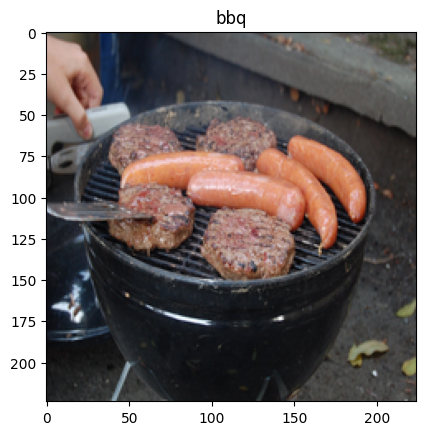

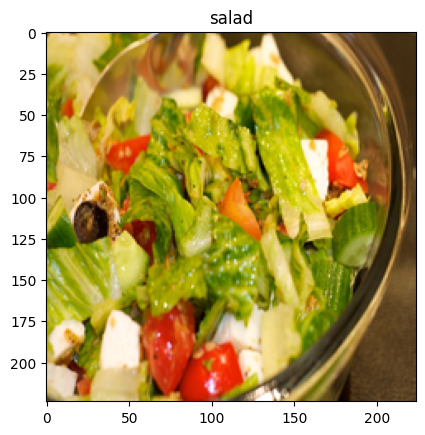

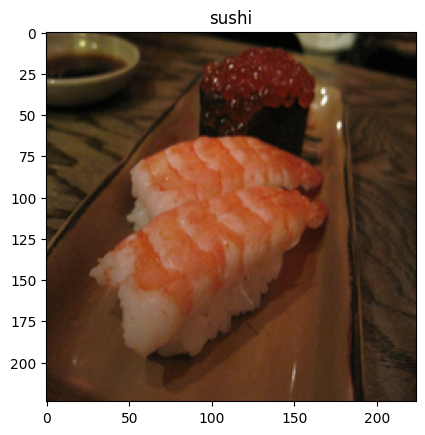

In [ ]:
plt.imshow(X_array[1000])
plt.title(y[1000])
plt.show()
plt.imshow(X_array[500])
plt.title(y[500])
plt.show()
plt.imshow(X_array[0])
plt.title(y[0])
plt.show()

Preprocess the labels (one-hot encodings)

In [ ]:
# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Transform to one hot encodings
min = np.min(y)
max = np.max(y)
print(min, max)
num_classes = max + 1
y = to_categorical(y, num_classes)

print("First label is now = ", y[0])

0 4
First label is now =  [0. 0. 0. 0. 1.]


## Testing and validation data split
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.1, shuffle=True, random_state=SEED)

# Split again training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

print(X_train.shape[0], "train samples")
print(X_val.shape[0], "validation samples")
print(X_test.shape[0], "test samples")

1038 train samples
260 validation samples
145 test samples


# Baseline model

This model represents the baseline, and it's defined as the best custom model seen in the labs, and will be used as a reference to see how other models perform.

In [ ]:
def CNNModel(input_shape=(32, 32, 3), num_classes=10):

    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(16, (3, 3), padding="same",  activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Our model

The model we will use is a wrapper class for the Keras Model class. In particular, we hold a Keras Model as a local variable, which is the result of fine-tuning a pretrained network whose name is specified as input to the constructor. The fine-tuning proceeds as follows:
1. Download the pretrained network and only extract the input and hidden layers
2. Freeze these layers as they are the feature extractors
3. Add a MLP head ontop with Dense, Dropout, GlobalAveragePooling2D, and BatchNormalization layers

The model is finally built with all the hyperparameters passed as input, together with fixed parameters for the loss (categorical_crossentropy), optimizer (Adam).

By definition of the model, the training is therefore limited to only the MLP head, in a transfer learning fashion.

Additionally, an input flag in the constructor dictates whether to activate the data augmentation for the training routine (random zoom in and out, random vertical flipping), which is applied to both training and validation data, and another flag in the fit function determines whether to activate the early stop to prevent overfitting in the training routine.

Finally, other utility functions are defined, which are direct function calls to the underlying Model's functions.

In [ ]:
class MyPTCNNModel:
    def __init__(self, model_name, num_classes, data_augmentation=False, num_units=16, learning_rate=1e-4, dropout_rate=0.5):
        self.num_units = num_units
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.data_augmentation = data_augmentation
        self.num_classes = num_classes

        self.build_model(model_name)

    def build_model(self, model_name):

        # Build the base
        if model_name == 'ResNet50':
          base = app.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == 'EfficientNetB0':
          base = app.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "DenseNet121":
          base = app.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "EfficientNetV2B0":
          base = app.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        elif model_name == "MobileNet":
          base = app.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        for layer in base.layers:
            layer.trainable = False

        # Build the head
        x = base.output
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units*4, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units*2, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_units, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = BatchNormalization()(x)
        head = Dense(units=self.num_classes, activation='softmax')(x)

        # Merge base and head
        self.model = Model(inputs=base.input, outputs=head)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           metrics=['accuracy'])

    def stop_early(self):
      # Early stop to prevent overfitting
      self.stop_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=3,
      )

    def fit(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=128, stop_early=True):
        if stop_early:
          self.stop_early()
        if self.data_augmentation:
          datagen_train = ImageDataGenerator(
              zoom_range=(0.8, 1.2),
              vertical_flip=True,
          )
          datagen_train.fit(X_train, seed=SEED)
          datagen_val = ImageDataGenerator(
              zoom_range=(0.8, 1.2),
              vertical_flip=True,
          )
          datagen_val.fit(X_val, seed=SEED)
          history = self.model.fit(
              datagen_train.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=SEED),
              validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size, shuffle=True, seed=SEED),
              epochs=epochs,
              callbacks=[self.stop_early]
              )
        else:
          history = self.model.fit(
              X_train, y_train,
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              epochs=epochs,
              callbacks=[self.stop_early]
              )
        return history

    def evaluate(self, X_test, y_test):
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        return test_loss, test_acc

    def summary(self):
        return self.model.summary()

    def save(self, path):
        return self.model.save(path)

    def predict(self, x):
        return self.model.predict(x)

# Training


##Helper functions

Define a function to plot training histories for different models (as in the lab).

In [ ]:
def plot_histories(history):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  for name in history:
      ax[0][0].plot(history[name].history["loss"], label=name)
      ax[0][0].set_title("loss")
      ax[0][0].legend()
      ax[0][1].plot(history[name].history["val_loss"], label=name)
      ax[0][1].set_title("val_loss")
      ax[0][1].legend()
      ax[1][0].plot(history[name].history["accuracy"], label=name)
      ax[1][0].set_title("accuracy")
      ax[1][0].legend()
      ax[1][1].plot(history[name].history["val_accuracy"], label=name)
      ax[1][1].set_title("val_accuracy")
      ax[1][1].legend()
  plt.tight_layout()

## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

### Data preprocessing

Before training, we need to resize the data to a smaller target, in order to reduce the number of trainable parameters to accomodate for the limited resources.

In [ ]:
# Define the target size
target_size = (32, 32)

# Resize images
resized_X_32 = resize_images(X, target_size)

# Convert to numpy array
X_array_32 = np.array([np.array(img) for img in resized_X_32])

# Split the data into training and testing sets
X_train_32, X_test_32, y_train_32, _ = train_test_split(X_array_32, y, test_size=0.1, shuffle=True, random_state=SEED)

# Split again training data into training and validation
X_train_32, X_val_32, _, _ = train_test_split(X_train_32, y_train_32, test_size=0.2, shuffle=True,  random_state=SEED) # for reproducibility

print(X_train_32.shape[0], "train samples")
print(X_val_32.shape[0], "validation samples")
print(X_test_32.shape[0], "test samples")

1038 train samples
260 validation samples
145 test samples


### Training the baseline

Fit the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,389 (2.64 MB)

 Trainable params: 691,365 (2.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3927 - loss: 1.7232 - val_accuracy: 0.2154 - val_loss: 37.8699
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5009 - loss: 1.3210 - val_accuracy: 0.2154 - val_loss: 17.3818
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5390 - loss: 1.2272 - val_accuracy: 0.3154 - val_loss: 6.3926
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5394 - loss: 1.2227 - val_accuracy: 0.3731 - val_loss: 5.5720
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5683 - loss: 1.1116 - val_accuracy: 0.2692 - val_loss: 7.2984
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5415 - loss: 1.1465 - val_accuracy: 0.3808 - val_loss: 3.8986
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5995 - loss: 1.0074 - val_accuracy: 0.2154 - val_loss: 5.5766
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6417 - loss: 0.9717 - val_accuracy: 0.2962 - val_loss: 4.0607

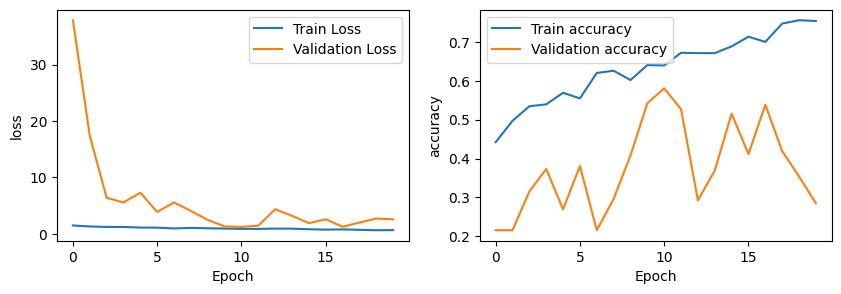

In [ ]:
batch_size = 128
epochs = 20

model = CNNModel(num_classes=num_classes)
model.summary()

history = model.fit(X_train_32, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val_32, y_val))
plot_history(history)

# Save the model
model.save('/content/DL_Ass2/models/baseline_model.keras')

After 20 epochs, the model is not achieving a satisfactory level of accuracy on the training set. One possible reason for this is the choice to resize the images, which results in a loss of information. To improve the results, we should train the model for a longer period of time and fine-tune the model hyperparameters. However, it should be noted that this baseline model is being used solely as a reference and will not be further modified.

## Choosing among pretrained models

We are going to fine-tune different models and choose the best performing with some standard predefined parameters.

###Training the models.

**NOTE**: the loop may not finish as the RAM could be exhausted before. We already trained the models and uploaded in the GitHub repo, therefore they are already in the workspace. Need to set **HEAVY_TRAINING** flag in the **Setup** Section to False if this behaviour is to be avoided entirely.

Training 5 fine-tuned models with augmentation.

In [ ]:
# STANDARD PREDEFINED PARAMETERS
NUMBER_OF_UNITS = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3
BATCH_SIZE = 128
EPOCHS = 10 # Only a few epochs should be needed to make the selection
AUGMENTATION = True
STOP_EARLY = True

models = ["ResNet50", "EfficientNetB0", "DenseNet121", "EfficientNetV2B0", "MobileNet"]

if HEAVY_TRAINING:
  histories = {}

  for name in models:
    backend.clear_session()  # to try to clear memory
    print("Training:", name, "...")
    model = MyPTCNNModel(name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)
    #print(model.summary())
    histories[name] = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)
    model.save('/content/' + name + '.keras')

  plot_histories(histories)

###Choose the best pretrained model

We are going to directly load the models from our GitHub repository for semplicity and to reduce cells' interdependencies, as the SEED should allow to train very similar models in the end, and reach the same conclusions.

In [ ]:
models = ["ResNet50", "EfficientNetB0", "DenseNet121", "EfficientNetV2B0", "MobileNet"]

validation_accuracies = []

for name in models:
  print("Model:", name)
  backend.clear_session()  # to try to clear memory
  model = keras.models.load_model('/content/DL_Ass2/models/' + name + '.keras')
  _, acc = model.evaluate(X_val, y_val)
  validation_accuracies.append(acc)

best_model_name = models[np.argmax(validation_accuracies)]
print("The best model in terms of validation accuracy is:", best_model_name)

Model: ResNet50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 545ms/step - accuracy: 0.9290 - loss: 0.2290
Model: EfficientNetB0
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - accuracy: 0.9670 - loss: 0.3011
Model: DenseNet121
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7739 - loss: 0.7428
Model: EfficientNetV2B0
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5147 - loss: 1.2189
Model: MobileNet
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.5736 - loss: 1.0839
The best model in terms of validation accuracy is: EfficientNetB0


## Tune the best model

**IMPORTANT**:

Before continuing, it should be noted that the searching of the hyperparameters for our best model is performed in the notebook "DL_Assignment2_Search.ipynb", since we have seen that the process causes non negligible memory leaks that impede the following cells to execute smoothly or run at all.

Therefore, it is suggested to move to the other notebook before proceeding with the reading of this one.

In any case, the code should run regardless, as the hyperparameters have already been searched and can be found in the workspace.

Once again, the SEED should cause the hyperparameters found to be the same as ours.

We will train a model with the best hyperparameters found in the search with data augmentation and one without data augmentation, to evaluate how the performances change.

### Train the tuned model

In [ ]:
# Read the JSON file and load the hyperparameters
with open("/content/DL_Ass2/best_hps.json", "r") as f:
    best_hps = json.load(f)

NUMBER_OF_UNITS = best_hps['units']
LEARNING_RATE = best_hps['learning_rate']
DROPOUT_RATE = best_hps['dropout_rate']
BATCH_SIZE = 128
EPOCHS = 30
AUGMENTATION = True
STOP_EARLY = True

if LIGHT_TRAINING: # If False we use the models that we have already trained and stored in GitHub

  model = MyPTCNNModel(best_model_name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)

  print(f"Training {best_model_name} for {EPOCHS} epochs...")

  history = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)

  plot_history(history)

  model.save('/content/DL_Ass2/models/' + best_model_name + '_tuned.keras')


###Train the non-augmented tuned model

In [ ]:
# Read the JSON file and load the hyperparameters
with open("/content/DL_Ass2/best_hps.json", "r") as f:
    best_hps = json.load(f)

NUMBER_OF_UNITS = best_hps['units']
LEARNING_RATE = best_hps['learning_rate']
DROPOUT_RATE = best_hps['dropout_rate']
BATCH_SIZE = 128
EPOCHS = 30
AUGMENTATION = False
STOP_EARLY = True

if LIGHT_TRAINING_NOAUG: # If False we use the models that we have already trained and stored in GitHub

  model = MyPTCNNModel(best_model_name, num_classes, data_augmentation=AUGMENTATION, num_units=NUMBER_OF_UNITS, learning_rate=LEARNING_RATE, dropout_rate=DROPOUT_RATE)

  print(f"Training {best_model_name} for {EPOCHS} epochs...")

  history = model.fit(X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE, stop_early=STOP_EARLY)

  plot_history(history)

  model.save('/content/DL_Ass2/models/' + best_model_name + '_tuned_noAug.keras')


#Evaluation


## Helper functions

We define a function to compute class-wise accuracies given a model and the testing data.

In [ ]:
def compute_class_accuracies(X_data, y_data, model):
  # The predicted probabilities for each class
  y_pred_probs = model.predict(X_data)

  # The corresponding predicted labels
  y_pred_labels = np.argmax(y_pred_probs, axis=1)

  # The corresponding true labels
  y_true_labels = np.argmax(y_data, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_true_labels, y_pred_labels)

  # Compute accuracies and weights for each class
  class_accuracies = []
  for class_label in range(len(cm)):
      class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
      class_accuracies.append(class_accuracy)

  # Print the classification report
  print(classification_report(y_true_labels, y_pred_labels))

  return class_accuracies

## Baseline evaluation

Print the loss and accuracy of the trained baseline model.

In [ ]:
# Remove previously used variable to free up space if present
if 'model' in locals():
    del model
    gc.collect()

base_model = keras.models.load_model('/content/DL_Ass2/models/baseline_model.keras')

base_score = base_model.evaluate(X_test_32, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 2.52948260307312
Test accuracy: 0.2896551787853241


##Tuned Models evaluation

Here we compute the class accuracies and F1 for the two tuned models, with and without augmentation.

In [ ]:
# TUNED AUGMENTED -------------------------------------------------------------

name = "EfficientNetB0_tuned"
dnn_model = keras.models.load_model('/content/DL_Ass2/models/'+ name +'.keras')

print("Model:", name)
# Compute class-wise accuracies of the tuned model with augmentation
class_accuracies = compute_class_accuracies(X_test, y_test, dnn_model)
# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

best_score = dnn_model.evaluate(X_test, y_test)
print(f"{name} accuracy: {best_score}")

# TUNED NOT AUGMENTED ---------------------------------------------------------

name = "EfficientNetB0_tuned_noAug"
dnn_model_noAug = keras.models.load_model('/content/DL_Ass2/models/'+ name +'.keras')

print("Model:", name)
# Compute class-wise accuracies of the tuned model without augmentation
class_accuracies_noAug = compute_class_accuracies(X_test, y_test, dnn_model_noAug)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies_noAug):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

best_score_noAug = dnn_model_noAug.evaluate(X_test, y_test)
print(f"{name} accuracy: {best_score_noAug}")

# -----------------------------------------------------------------------------
# TABLES --- Evaluate and print results for overall accuracy   ----------------------------------------------------------------------
print("")
print("To sum up:")
table = PrettyTable()
print("")
table.field_names = ["Model", "Accuracy", "Loss", "Improvement of the Baseline"]
# Add data to the table
table.add_row(["Base_line:",base_score[1], base_score[0], (str(0)+"%")])
table.add_row(["EfficientNetB0_tuned:",best_score[1], best_score[0], (str(100*(best_score[1]-base_score[1])/base_score[1])+"%")])
table.add_row(["EfficientNetB0_tuned_noAug:", best_score_noAug[1], best_score_noAug[0], (str(100*(best_score_noAug[1]-base_score[1])/base_score[1])+"%")])


# Print the table
print(table)

Model: EfficientNetB0_tuned


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.91      0.95        23
           2       1.00      0.97      0.98        33
           3       0.94      1.00      0.97        17
           4       0.94      0.97      0.96        33

    accuracy                           0.97       145
   macro avg       0.97      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145

Class 0: Accuracy 1.00
Class 1: Accuracy 0.91
Class 2: Accuracy 0.97
Class 3: Accuracy 1.00
Class 4: Accuracy 0.97
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 799ms/step - accuracy: 0.9808 - loss: 0.0900
EfficientNetB0_tuned accuracy: [0.1110980287194252, 0.9724137783050537]
Model: EfficientNetB0_tuned_noAug
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.96

The final results of both models are satisfactory as the test accuracy is high. Additionally, both models effectively distinguish between classes with high precision and recall. In conclusion, both models are valid alternatives for this task and both perform better than the starting baseline. Of course, the model trained using data augmentation requires more time to train and does not lead to improvement. In section 'Transformation Test', we will discuss the model's robustness to input transformations.

## Transformation test

In [ ]:
###############################################################################################################################################################
## This function calculates the accuracies of models with and without data augmentation by permuting X_test. It also displays the performance of n examples. ##
###############################################################################################################################################################

def compare_accuracies_with_augmentation(model1, model2, X_test, y_test, n):
  # Create the same ImageDataGenerator for augmentation as in the definition of our model
  datagen = ImageDataGenerator(
    zoom_range=(0.8, 1.2),
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=30,
    shear_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
)
  # Lists to store augmented data
  X_augmented = []
  y_augmented = []
  # The predicted probabilities for each class
  y_pred_probs1 = model1.predict(X_test)
  y_pred_probs2 = model2.predict(X_test)
  # The corresponding predicted labels
  y_pred_labels1 = np.argmax(y_pred_probs1, axis=1)
  y_pred_labels2 = np.argmax(y_pred_probs2, axis=1)
  AccYTND = accuracy_score(y_test, to_categorical(y_pred_labels1))
  AccNTND = accuracy_score(y_test, to_categorical(y_pred_labels2))
  # Iterate through all training examples
  for i in range(len(X_test)):
      # Reshape the image to (1, height, width, channels) for flow method
      img = X_test[i].reshape((1,) + X_test[i].shape)

      # Generate augmented images and store in X_augmented and y_augmented
      for batch, labels_batch in datagen.flow(img, y_test[i].reshape(1, -1), batch_size=1):
          X_augmented.append(batch[0].reshape(X_test[i].shape))
          y_augmented.append(labels_batch[0])
          break  # Exit the loop after one augmented image
  # Convert lists to NumPy arrays
  X_augmented = np.array(X_augmented)
  y_augmented = np.array(y_augmented)
  #The predicted probabilities for each class
  y_pred_probs_aug1 = model1.predict(X_augmented)
  y_pred_probs_aug2 = model2.predict(X_augmented)
  # The corresponding predicted labels
  y_pred_labels_aug1 = np.argmax(y_pred_probs_aug1, axis=1)
  y_pred_labels_aug2 = np.argmax(y_pred_probs_aug2, axis=1)
  AccYTYD = accuracy_score(y_augmented, to_categorical(y_pred_labels_aug1))
  AccNTYD = accuracy_score(y_augmented, to_categorical(y_pred_labels_aug2))
  X_augmented /= 255
  # TABLE ---------------------------------------------------------------
  table = PrettyTable()
  table.field_names = ["Model", "Accuracy X_test augmented", "Accuracy X_test"]
  table.add_row(["EfficientNetB0_tuned:",AccYTYD, AccYTND])
  table.add_row(["EfficientNetB0_tuned_noAug:", AccNTYD, AccNTND])
  print(table)
  # Display the first n examples
  for i in range(n):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.imshow(X_test[i].reshape(X_test[i].shape), cmap="gray")
        plt.title(f'No Data Aug: True: {np.argmax(y_test[i])}, Predicted: {y_pred_labels1[i]}, Probability: {y_pred_probs1[i, y_pred_labels1[i]]:.4f}')

        plt.subplot(2, 2, 2)
        plt.imshow(X_augmented[i].reshape(X_augmented[i].shape), cmap="gray")
        plt.title(f'Data Aug: True: {np.argmax(y_augmented[i])}, Predicted: {y_pred_labels_aug1[i]}, Probability: {y_pred_probs_aug1[i, y_pred_labels_aug1[i]]:.4f}')

        plt.subplot(2, 2, 3)
        plt.imshow(X_test[i].reshape(X_test[i].shape), cmap="gray")
        plt.title(f'No Data Aug: True: {np.argmax(y_test[i])}, Predicted: {y_pred_labels2[i]}, Probability: {y_pred_probs2[i, y_pred_labels2[i]]:.4f}')

        plt.subplot(2, 2, 4)
        plt.imshow(X_augmented[i].reshape(X_augmented[i].shape), cmap="gray")
        plt.title(f'Data Aug: True: {np.argmax(y_augmented[i])}, Predicted: {y_pred_labels_aug2[i]}, Probability: {y_pred_probs_aug2[i, y_pred_labels_aug2[i]]:.4f}')

        plt.tight_layout(pad=4.0)
        plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
+-----------------------------+---------------------------+--------------------+
|            Model            | Accuracy X_test augmented |  Accuracy X_test   |
+-----------------------------+---------------------------+--------------------+
|    EfficientNetB0_tuned:    |     0.9517241379310345    | 0.9724137931034482 |
| EfficientNetB0_tuned_noAug: |     0.9655172413793104    | 0.9724137931034482 |
+-----------------------------+---------------------------+--------------------+


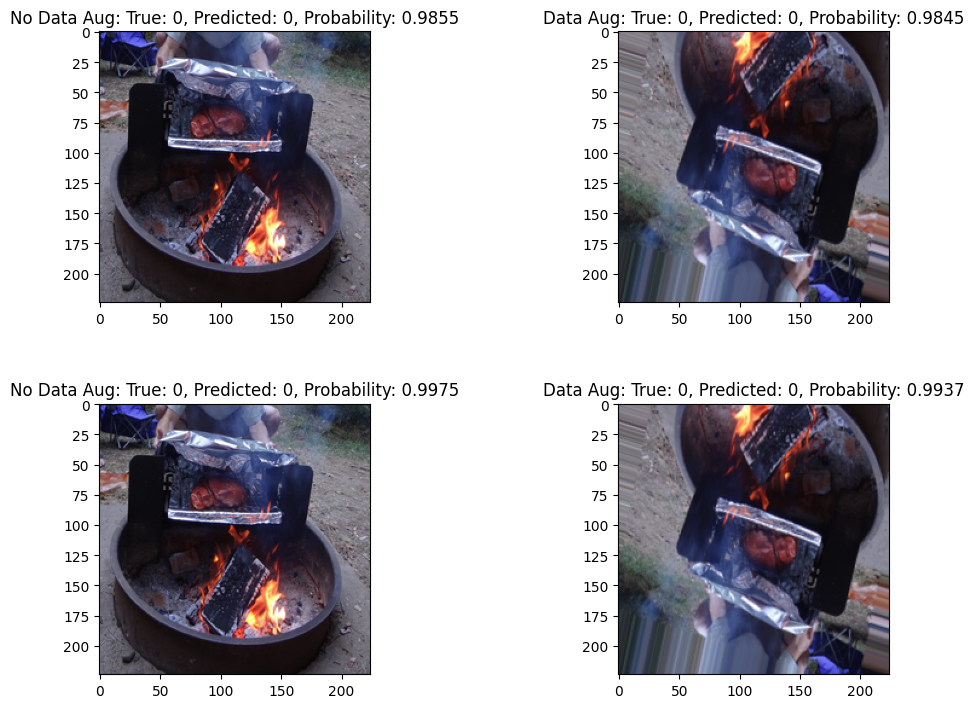

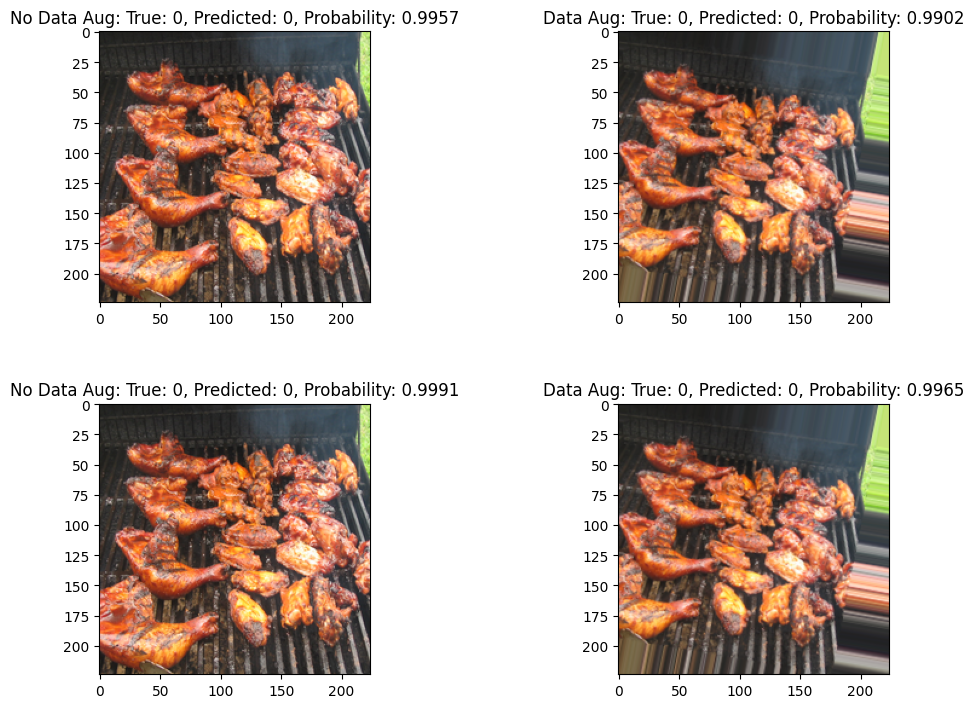

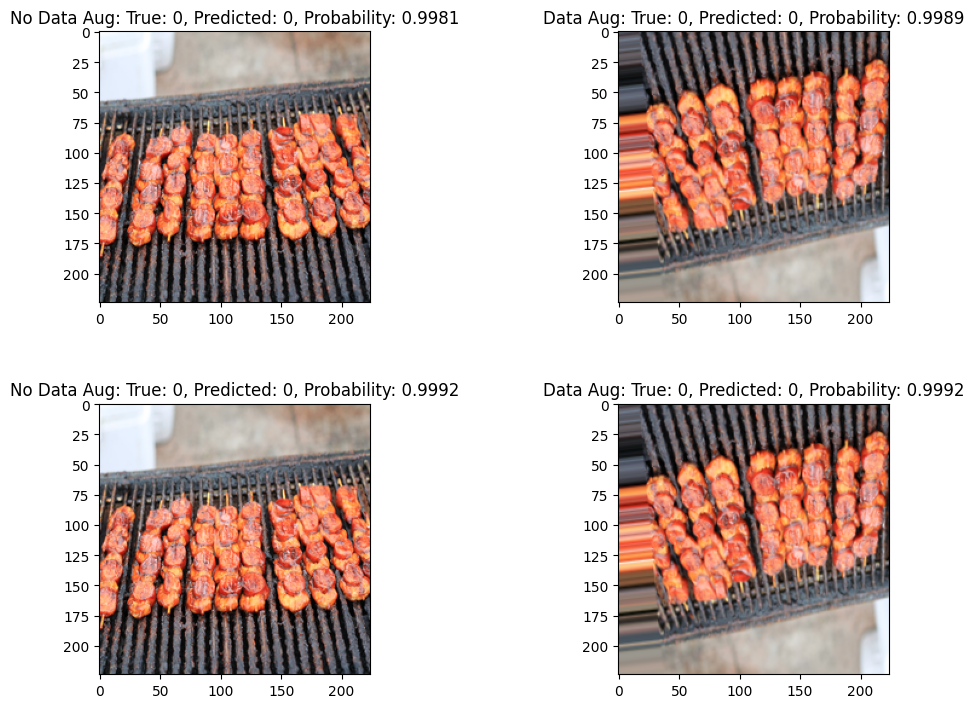

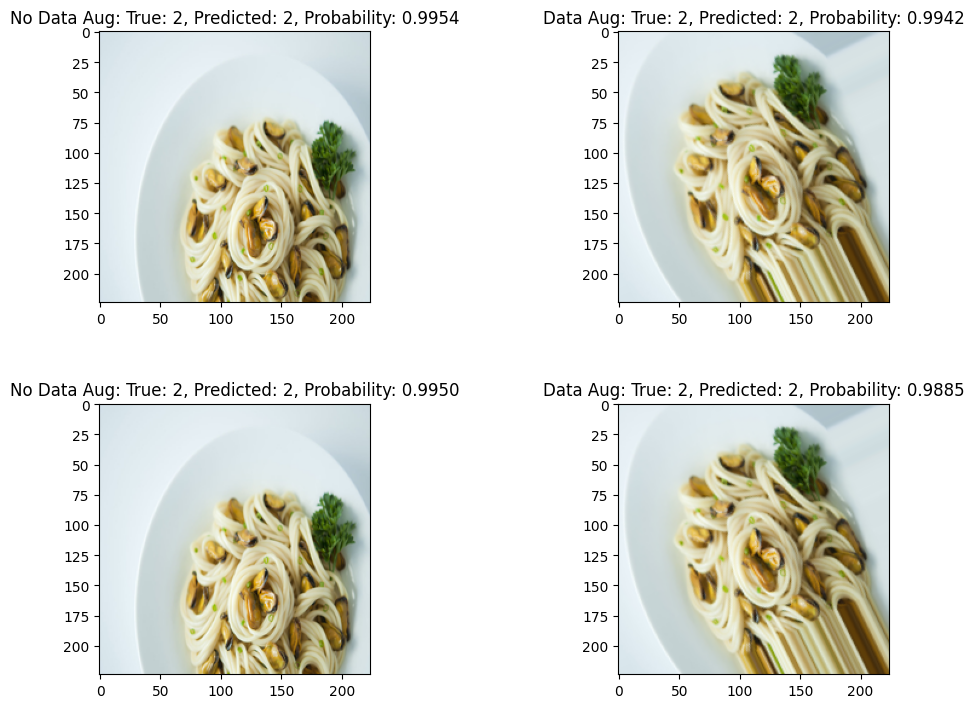

In [ ]:
compare_accuracies_with_augmentation(dnn_model, dnn_model_noAug, X_test, y_test, 4)
# The first row shows the predictions of the EfficientNetB0_tuned (Trained WITH data augmentation)
# The second row shows the predictions of the EfficientNetB0_tuned_noAug (Trained WITHOUT data augmentation)

It is evident that the model trained with data augmentation performs worse when faced with permutated inputs. This is because training the model with permuted input to achieve robustness to permutation is a more challenging task than training with non-permuted data. Therefore, the model requires more iterations to achieve better robustness on permuted data. Furthermore, since the permutation does not significantly alter the images in terms of brightness or pixel relations, the model trained without data augmentation is capable of making accurate predictions. One potential improvement could be to incorporate techniques such as Pad&Crop, MixUp, or CutOut for the augmented model.
Exploding these techniques needs more computational power and of course more iterations, so in the end we did not implement them.

In conclusion, we have determined that the improvements resulting from the use of these techniques would not be significant enough to justify their implementation for this task. In the end, we have agreed that it is better to not use data augmentation for this particular task.

# Explainable AI

In this section we will use some explanatory tools to understand why the two pre-trained models and also the base line model have different performances.

Explainable AI addresses the problem of revealing the reasoning behind AI outcomes, as they function as black boxes, producing results without being transparent.

## Helper functions

Functions that plots and returns the N worst predictions.

In [ ]:
def find_top_N_misclassified(model, X_test, N):
  # Make predictions on the test data
  predictions = model.predict(X_test)

  # Find the misclassification confidence for each prediction
  misclassification_confidence = np.max(predictions, axis=1)

  y_true_labels = np.argmax(y_test, axis=1)

  # Calculate the difference between the predicted labels and the true labels
  difference = misclassification_confidence - y_true_labels

  # Find the indices of the top N most misclassified images
  top_misclassified_indices = np.argsort(np.abs(difference))[-N:]

  # Plot the top N most misclassified images
  plt.figure(figsize=(10, 10))
  for i, index in enumerate(top_misclassified_indices):
      plt.subplot(3, 3, i + 1)
      plt.imshow(X_test[index])
      plt.title(f"True: {y_true_labels[index]}, Predicted: {np.argmax(predictions[index])}\nMisclassification Confidence: {misclassification_confidence[index]}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

  # Store the N most misclassified images
  misclassified_images = []

  # Iterate over the top misclassified indices and store the corresponding images
  for index in top_misclassified_indices:
      misclassified_images.append(X_test[index])
  return misclassified_images

### Layer activations

In [ ]:
#define the function to get the access to the layers input
def get_layer_output(model, layer_name):
    return Model(model.inputs,
                 model.get_layer(layer_name).output)

In [ ]:
#param model, trained model
#param test_instance , test set
def layer_activation(model,test_instance,layer_name="conv1_conv"):
  num_filters = dnn_model.get_layer(layer_name).output.shape[-1]
  get_activations = get_layer_output(model, layer_name)
  activations = get_activations(np.expand_dims(test_instance, axis=0))[0]
  rows_cols = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  fig.suptitle(layer_name)
  for filter_idx in range(num_filters):
      ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(activations[:, :, filter_idx])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

### Maximally activating images

In [ ]:
def get_excitement(images, model, layer_name, filter_idx, batch_size=128):
    excitements = np.array([])
    get_activations = get_layer_output(model, layer_name)
    for i in range(0, len(images), batch_size):
        activations = get_activations(images[i : i + batch_size])[:, :, :, filter_idx]
        excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
    return excitements

In [ ]:
def get_top_exciting_instances(images, model,
                               layer_name, filter_idx, top=4):
    excitements = get_excitement(images, model,
                                 layer_name, filter_idx)
    excitements_idx = np.argsort(excitements)[-top:][::-1]
    return excitements_idx, excitements[excitements_idx]

In [ ]:
def show_exciting_images(images, model, layer_name, filter_idx, top=4):
    excitements_idx, excitements = get_top_exciting_instances(images, model, layer_name, filter_idx, top)
    rows_cols = int(np.ceil(np.sqrt(top)))
    fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
    for i, excitement_idx in enumerate(excitements_idx):
        ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
    fig.tight_layout()
    plt.show()

### Deconvolving an activation

In [ ]:
def make_deconvolving_model(model, layer_name, filter_idx):
    conv_layers = [layer.name for layer in model.layers if layer.name.startswith("conv") and layer.name.endswith("conv")]
    layer_idx = conv_layers.index(layer_name)
    dec_model = Sequential()
    dec_model.add(Input(model.get_layer(conv_layers[0]).output.shape[1:3] + (1,)))
    for idx in range(layer_idx, 0, -1):
        original = model.get_layer(conv_layers[idx])
        prev = model.get_layer(conv_layers[idx - 1])
        deconv = Conv2DTranspose(
            prev.filters, kernel_size=prev.kernel_size, padding="same", activation="relu", use_bias=False
        )
        dec_model.add(deconv)
    original = model.get_layer(conv_layers[0])
    final = Conv2DTranspose(3, kernel_size=original.kernel_size, padding="same", activation="relu", use_bias=False)
    dec_model.add(final)
    for idx, lyr in enumerate(dec_model.layers):
        original = model.get_layer(conv_layers[layer_idx - idx])
        orig_weights = original.get_weights()[0]
        if idx == 0:
            orig_weights = orig_weights[..., filter_idx, None]
        lyr.set_weights([orig_weights])
    return dec_model


conv_layers = [layer.name for layer in dnn_model.layers if layer.name.startswith("conv")]
layer_name = conv_layers[1]

filter_idx = 7

num_filters = dnn_model.get_layer(layer_name).output.shape[-1]
get_activations = get_layer_output(dnn_model, layer_name)
activations = get_activations(np.expand_dims(X_test[0,:,:,:], axis=0))[0]
deconvolving_model = make_deconvolving_model(dnn_model, layer_name,filter_idx)
preds = deconvolving_model.predict(np.expand_dims(activations, axis=3))
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for act in range(len(activations)):
    ax[act // 2][act % 2].imshow(preds[act])
fig.tight_layout()

### Saliency maps

In [ ]:

def generate_saliency_map(model, score, x, smooth_samples=20, smooth_noise=0.2):
    saliency = Saliency(model, clone=False)
    saliency_map = saliency(score, x, smooth_samples=smooth_samples, smooth_noise=smooth_noise)
    saliency_map = normalize(saliency_map)
    return saliency_map

###LIME

In [ ]:
def lime_explain(model, image,  top_labels=5, hide_color=0, num_samples=1, num_features=5):
    # Create a Lime explainer instance for images
    explainer = lime_image.LimeImageExplainer()


    # Define a function to predict with your model
    def predict_fn(images):
        return model.predict(images)

    # Generate explanations
    explanation = explainer.explain_instance(image,
                                             predict_fn,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             num_samples=num_samples)

    # Visualize the explanations
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=num_features,
                                                hide_rest=False)
    return mark_boundaries(temp / 2 + 0.5, mask)


##Results

In [ ]:
#Layer activation

#Visualize for pretrained model
print("Pretrained network Maximally activating images")
layer_activation(dnn_model,X_test[0,:,:,:], layer_name="conv2_block1_1_conv")
layer_activation(dnn_model,X_test[0,:,:,:])

In [ ]:
#Maximally activating images for each CNN model we have created

#visualize for pretrained model
conv_layers = [layer.name for layer in dnn_model.layers if layer.name.startswith("conv")]
print("Pretrained network Maximally activating images")
show_exciting_images(X_train, dnn_model, conv_layers[1], filter_idx=3)

In [ ]:
#saliency matrix

print("results for Pretraned network")

# Create a CategoricalScore object
score = CategoricalScore([0])

# Generate saliency map
saliency_map = generate_saliency_map(dnn_model, score, X_train[0,:,:,:])

subplot_args = {
    'nrows': 1,
    'ncols': 1,
    'figsize': (5, 4),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
# Plot the saliency map
f, ax = plt.subplots(**subplot_args)
ax.imshow(saliency_map[0], cmap='Reds')
plt.tight_layout()
plt.show()

In [ ]:
#lime
print("lime for Pretarined lecture ")
explanation_output=lime_explain(dnn_model,X_train[0,:,:,:])
# Display the explanation using Matplotlib
plt.imshow(explanation_output)
plt.axis('off')
plt.show()